In [42]:
# Data manipulation, refer: https://cienciadedatos.net/documentos/py29-forecasting-electricity-power-demand-python
# ==============================================================================
import numpy as np
import pandas as pd
# from astral.sun import sun
# from astral import LocationInfo
from skforecast.datasets import fetch_dataset

# Plots
# ==============================================================================
import matplotlib.pyplot as plt





## This notebook use "Demand" and "Temperature", "Holiday" 3 features for prediction.
- We DO NOT rescale/normalize based on training dataset

## Refer to: https://cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html

In [43]:
data = fetch_dataset(name='vic_electricity', raw=True)
data.info()

vic_electricity
---------------
Half-hourly electricity demand for Victoria, Australia
O'Hara-Wild M, Hyndman R, Wang E, Godahewa R (2022).tsibbledata: Diverse
Datasets for 'tsibble'. https://tsibbledata.tidyverts.org/,
https://github.com/tidyverts/tsibbledata/.
https://tsibbledata.tidyverts.org/reference/vic_elec.html
Shape of the dataset: (52608, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52608 entries, 0 to 52607
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Time         52608 non-null  object 
 1   Demand       52608 non-null  float64
 2   Temperature  52608 non-null  float64
 3   Date         52608 non-null  object 
 4   Holiday      52608 non-null  bool   
dtypes: bool(1), float64(2), object(2)
memory usage: 1.7+ MB


In [44]:
data

,Time,Demand,Temperature,Date,Holiday
0,2011-12-31T13:00:00Z,4382.825174,21.40,2012-01-01,True
1,2011-12-31T13:30:00Z,4263.365526,21.05,2012-01-01,True
2,2011-12-31T14:00:00Z,4048.966046,20.70,2012-01-01,True
3,2011-12-31T14:30:00Z,3877.563330,20.55,2012-01-01,True
4,2011-12-31T15:00:00Z,4036.229746,20.40,2012-01-01,True
...,...,...,...,...,...
52603,2014-12-31T10:30:00Z,3873.448714,19.00,2014-12-31,False
52604,2014-12-31T11:00:00Z,3791.637322,18.50,2014-12-31,False
52605,2014-12-31T11:30:00Z,3724.835666,17.70,2014-12-31,False
52606,2014-12-31T12:00:00Z,3761.886854,17.30,2014-12-31,False


In [40]:
# Data preparation
# ==============================================================================
data = data.copy()
data['Time'] = pd.to_datetime(data['Time'], format='%Y-%m-%dT%H:%M:%SZ')
data = data.set_index('Time') # use time as index
data = data.asfreq('30min').ffill() # chunch as 30min time resolution and forward fill missing data
data = data.sort_index() # sort by time order
data.head(4)

,Demand,Temperature,Date,Holiday
Time,,,,
2011-12-31 13:00:00,4382.825174,21.40,2012-01-01,True
2011-12-31 13:30:00,4263.365526,21.05,2012-01-01,True
2011-12-31 14:00:00,4048.966046,20.70,2012-01-01,True
2011-12-31 14:30:00,3877.563330,20.55,2012-01-01,True


In [10]:
# Aggregating in 1H intervals
# ==============================================================================
# The Date column is eliminated so that it does not generate an error when aggregating.

data = (
    data
    .resample(rule="h", closed="left", label="right")
    .agg({
        "Demand": "mean",
        "Temperature": "mean",
        "Holiday": "mean",
    })
)
data.head(4)

,Demand,Temperature,Holiday
Time,,,
2011-12-31 14:00:00,4323.095350,21.225,1.0
2011-12-31 15:00:00,3963.264688,20.625,1.0
2011-12-31 16:00:00,3950.913495,20.325,1.0
2011-12-31 17:00:00,3627.860675,19.850,1.0


In [11]:
data.tail()

,Demand,Temperature,Holiday
Time,,,
2014-12-31 09:00:00,4069.625550,21.60,0.0
2014-12-31 10:00:00,3909.230704,20.30,0.0
2014-12-31 11:00:00,3900.600901,19.65,0.0
2014-12-31 12:00:00,3758.236494,18.10,0.0
2014-12-31 13:00:00,3785.650720,17.20,0.0


In [12]:
# Split data into train-val-test set
# Note that "loc" function includes both the start and the stop are included
end_train = '2013-12-31 23:59:00'
start_val = '2014-01-01 00:00:00'
end_validation = '2014-11-30 23:59:00'
start_test = '2014-12-01 00:00:00'


data_train = data.loc[: end_train, :].copy()
data_val   = data.loc[start_val:end_validation, :].copy()
data_test  = data.loc[start_test: , :].copy()

print(f"Train dates      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Validation dates : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")



Train dates      : 2011-12-31 14:00:00 --- 2013-12-31 23:00:00  (n=17554)
Validation dates : 2014-01-01 00:00:00 --- 2014-11-30 23:00:00  (n=8016)
Test dates       : 2014-12-01 00:00:00 --- 2014-12-31 13:00:00  (n=734)


In [13]:
data_train.head(5)

,Demand,Temperature,Holiday
Time,,,
2011-12-31 14:00:00,4323.095350,21.225,1.0
2011-12-31 15:00:00,3963.264688,20.625,1.0
2011-12-31 16:00:00,3950.913495,20.325,1.0
2011-12-31 17:00:00,3627.860675,19.850,1.0
2011-12-31 18:00:00,3396.251676,19.025,1.0


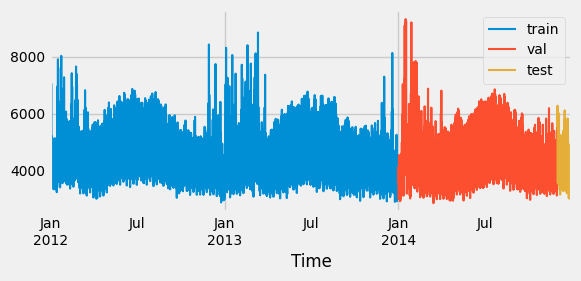

In [45]:
fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['Demand'].plot(ax=ax, label='train')
data_val['Demand'].plot(ax=ax, label='val')
data_test['Demand'].plot(ax=ax, label='test')
ax.legend()

## Using ForeecasterAutoreg class to build model and

In [27]:


# Modeling and Forecasting
# ==============================================================================
import sklearn
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import skforecast
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster
# import shap


# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 6
             )
forecaster.fit(y=data_train['Demand'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Exogenous variables names: None 
Training range: [Timestamp('2011-12-31 14:00:00'), Timestamp('2013-12-31 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: h 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2024-09-18 16:33:04 
Last fit date: 2024-09-18 16:33:16 
Skforecast version: 0.13.0 
Python version: 3.12.5 
Fore

In [35]:
# Predictions on validation set , here we predict the 0th to 1000th data point in the validationset, not using all the validation set (becasue the result is very off for long-term prediction) 
# ==============================================================================
num_data_pred = 500
steps = len(data_val['Demand'][:num_data_pred])
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2014-01-01 00:00:00    3645.269572
2014-01-01 01:00:00    3811.783441
2014-01-01 02:00:00    3899.029980
2014-01-01 03:00:00    3901.795102
2014-01-01 04:00:00    3896.856000
Freq: h, Name: pred, dtype: float64

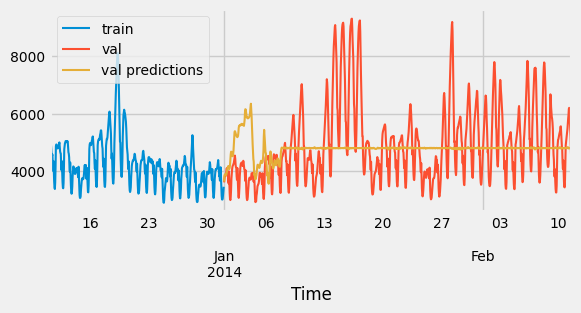

In [37]:
# Plot predictions versus test data
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['Demand'][-500:].plot(ax=ax, label='train')
data_val['Demand'][:num_data_pred].plot(ax=ax, label='val')
predictions.plot(ax=ax, label='val predictions')
ax.legend()